### Importing all the required libraries 

In [1]:
from sklearn.manifold import TSNE
import pandas as pd
import sqlite3
import numpy as np
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

C:\Users\yogesh.dayma\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


<h5>To perform all the operation we need data and it is stored in the SQLite Database.
We have to connect to the database and read the data from the database into a pandas dataframe.
To improve the results we are not reading the data which are having Score=3</h5>

In [2]:
#Downlaod the dataset from the link provided in ReadMe

con= sqlite3.Connection("database.sqlite")
filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3",con)

In [3]:
##Mapping the score colum to either 1 or 0 depending upon the existing score if it is greater than 3 or less than 3
#and storing it back to the dataframe
def partition(x):
    if x<3:
        return 0
    return 1
actualScore = filtered_data['Score']
positivenegative = actualScore.map(partition)
filtered_data['Score'] = positivenegative


In [4]:
#Sorting the data based on ProductId and removing the duplicates from the dataframe 

sorted_data = filtered_data.sort_values('ProductId',axis = 0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)

<h5> Taking first 2000 reviews as an input which will help us to excute the code faster </h5>

In [5]:
final2k = final[:2000]

## Bag of Words

In [6]:
#Using Count vectorizer to count the number of words present in the reviews/document for first 2000 reviews
CV = CountVectorizer()
BOW = CV.fit_transform(final2k["Text"].values)

In [7]:
#Initializing TSNE with components(dimensions) = 2 Perplexitiy 50 and 500 iterations on the Bag of words array
TSNE_Data = TSNE(n_components=2,perplexity=50,n_iter=500).fit_transform(BOW.toarray())

In [9]:
Score2K = filtered_data["Score"][:2000] # Taking first 2000 score to append to the result of the TSNE which will help us in plotting

#appending the data from TSNE's output to a data frame which we will use to plot using seaborn
TSNE_Data = np.vstack((TSNE_Data.T,Score2K)).T
TSNE_Dataframe = pd.DataFrame(data = TSNE_Data, columns=('Dim1','Dim2','Label'))

### Plotting the T-SNE for Bag of Words

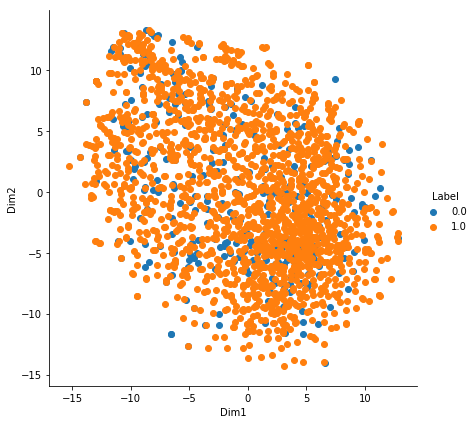

In [10]:
sns.FacetGrid(TSNE_Dataframe, hue = 'Label' , size=6 ).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.show()

In [14]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [15]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final2k['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if(final2k['Score'].values)[i] == 1:
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final2k['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    

    final_string.append(str1)
    i+=1

In [18]:
    #############---- storing the data into .sqlite file ------########################
final2k['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final2k['CleanedText']=final2k['CleanedText'].str.decode("utf-8")
    # store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
             index=True, index_label=None, chunksize=None, dtype=None)
conn.close()

with open('positive_words2K.pkl', 'wb') as f:
 pickle.dump(all_positive_words, f)
with open('negitive_words2K.pkl', 'wb') as f:
 pickle.dump(all_negative_words, f)

## TFIDF 

In [19]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2)) #Creating an object of TfidfVectorizer of bigram
final_tf_idf = tf_idf_vect.fit_transform(final2k['CleanedText'].values)

In [20]:
#Initializing TSNE with components(dimensions) = 2 Perplexitiy 50 and 500 iterations on the Bag of words array
TSNE_Data = TSNE(n_components=2,perplexity=50,n_iter=500).fit_transform(final_tf_idf.toarray())

In [21]:
#appending the data from TSNE's output to a data frame which we will use to plot using seaborn
TSNE_Data = np.vstack((TSNE_Data.T,Score2K)).T
TSNE_Dataframe = pd.DataFrame(data = TSNE_Data, columns=('Dim1','Dim2','Label'))


### Plotting T-SNE for TFIDF

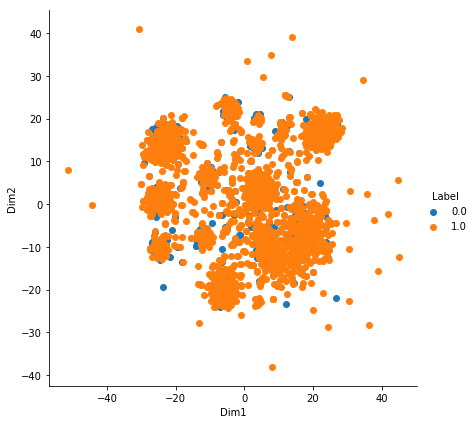

In [22]:
sns.FacetGrid(TSNE_Dataframe, hue = 'Label' , size=6 ).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.show()

### Training our own Word2Vec model using our amazon reviws data corpus

In [23]:
i=0
list_of_sent = []
for sent in final2k['CleanedText'].values:
    list_of_sent.append(sent.split())

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

## Avg Word2Vec

In [24]:
from tqdm import tqdm
w2v_words = list(w2v_model.wv.vocab)
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 243.52it/s]


### Plotting T-SNE for Avg Word2Vec

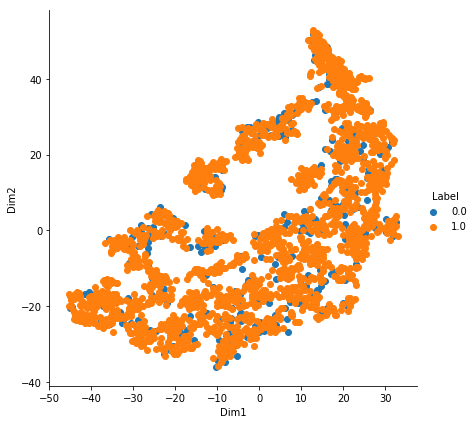

In [25]:
TSNE_Data = TSNE(n_components=2,perplexity=50,n_iter=1000).fit_transform(np.asarray(sent_vectors))
#appending the data from TSNE's output to a data frame which we will use to plot using seaborn
TSNE_Data = np.vstack((TSNE_Data.T,Score2K)).T
TSNE_Dataframe = pd.DataFrame(data = TSNE_Data, columns=('Dim1','Dim2','Label'))
sns.FacetGrid(TSNE_Dataframe, hue = 'Label' , height=6 ).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.show()

## TFIDF Word2Vec

In [26]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final2k['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [28]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 193.86it/s]


### Plotting T-SNE for TFIDF Word2Vec

In [29]:
TSNE_Data = TSNE(n_components=2,perplexity=50,n_iter=1000).fit_transform(np.asarray(tfidf_sent_vectors))
#appending the data from TSNE's output to a data frame which we will use to plot using seaborn
TSNE_Data = np.vstack((TSNE_Data.T,Score2K)).T
TSNE_Dataframe = pd.DataFrame(data = TSNE_Data, columns=('Dim1','Dim2','Label'))


<function matplotlib.pyplot.show(*args, **kw)>

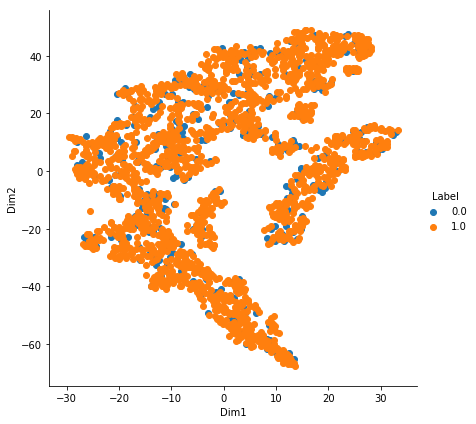

In [30]:
sns.FacetGrid(TSNE_Dataframe,hue= 'Label',height=6).map(plt.scatter, 'Dim1','Dim2').add_legend()
plt.show